In [1]:
# imports
import numpy as np
np.random.seed(9)
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
import pandas as pd
from gensim import downloader
from gensim.parsing.preprocessing import strip_punctuation
from gensim.utils import simple_preprocess 
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# checking available pretrained models in gensim
list(downloader.info()['models'])

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [3]:
# picking model to work with
print(list(downloader.info()['models']['glove-wiki-gigaword-50'].items()))

[('num_records', 400000), ('file_size', 69182535), ('base_dataset', 'Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)'), ('reader_code', 'https://github.com/RaRe-Technologies/gensim-data/releases/download/glove-wiki-gigaword-50/__init__.py'), ('license', 'http://opendatacommons.org/licenses/pddl/'), ('parameters', {'dimension': 50}), ('description', 'Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/).'), ('preprocessing', 'Converted to w2v format with `python -m gensim.scripts.glove2word2vec -i <fname> -o glove-wiki-gigaword-50.txt`.'), ('read_more', ['https://nlp.stanford.edu/projects/glove/', 'https://nlp.stanford.edu/pubs/glove.pdf']), ('checksum', 'c289bc5d7f2f02c6dc9f2f9b67641813'), ('file_name', 'glove-wiki-gigaword-50.gz'), ('parts', 1)]


In [4]:
# loading pretrained model
wv = downloader.load('glove-wiki-gigaword-50')

In [5]:
# loading dataset
df = pd.read_csv('/content/fake_real_news_dataset.csv')
df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [6]:
# getting info of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2422 entries, 0 to 2421
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2422 non-null   object
 1   label   2422 non-null   object
dtypes: object(2)
memory usage: 38.0+ KB


In [7]:
# checking whether dataset is imbalanced
df['label'].value_counts()

REAL    1212
FAKE    1210
Name: label, dtype: int64

In [8]:
# encoding target feature
df['label_encoded'] = df['label'].map({'FAKE':0, 'REAL':1})
df.head()

,text,label,label_encoded
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,It's primary day in New York and front-runners...,REAL,1


In [9]:
# removing punctuations
df['processed'] = df['text'].apply(strip_punctuation)
df.head()

,text,label,label_encoded,processed
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0,Daniel Greenfield a Shillman Journalism Fello...
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,1,U S Secretary of State John F Kerry said Mon...
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0,— Kaydee King KaydeeKing November 9 2016 Th...
4,It's primary day in New York and front-runners...,REAL,1,It s primary day in New York and front runners...


In [10]:
# text preprocessing; lower casing, tokenization
df['processed'] = df['processed'].apply(simple_preprocess)
df.head()

,text,label,label_encoded,processed
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0,"[daniel, greenfield, shillman, journalism, fel..."
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0,"[google, pinterest, digg, linkedin, reddit, st..."
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,1,"[secretary, of, state, john, kerry, said, mond..."
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0,"[kaydee, king, kaydeeking, november, the, less..."
4,It's primary day in New York and front-runners...,REAL,1,"[it, primary, day, in, new, york, and, front, ..."


In [11]:
# removing stopwords
stopwords = stopwords.words('english')
def remove_stopwords(text):
  removed_stopwords = [word for word in text if word not in stopwords]
  return removed_stopwords
df['processed'] = df['processed'].apply(lambda x: remove_stopwords(x))
df.head()

,text,label,label_encoded,processed
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0,"[daniel, greenfield, shillman, journalism, fel..."
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0,"[google, pinterest, digg, linkedin, reddit, st..."
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,1,"[secretary, state, john, kerry, said, monday, ..."
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0,"[kaydee, king, kaydeeking, november, lesson, t..."
4,It's primary day in New York and front-runners...,REAL,1,"[primary, day, new, york, front, runners, hill..."


In [12]:
# lemmatization
lemma = WordNetLemmatizer()
def lemmatization(text):
  lemmatized_text = [lemma.lemmatize(word) for word in text]
  return lemmatized_text
df['processed'] = df['processed'].apply(lambda x: lemmatization(x))
df.head()

,text,label,label_encoded,processed
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0,"[daniel, greenfield, shillman, journalism, fel..."
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0,"[google, pinterest, digg, linkedin, reddit, st..."
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,1,"[secretary, state, john, kerry, said, monday, ..."
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0,"[kaydee, king, kaydeeking, november, lesson, t..."
4,It's primary day in New York and front-runners...,REAL,1,"[primary, day, new, york, front, runner, hilla..."


In [13]:
# getting mean vectors from pretrained model 
df['vector'] = df['processed'].apply(wv.get_mean_vector)
df.head()

,text,label,label_encoded,processed,vector
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0,"[daniel, greenfield, shillman, journalism, fel...","[0.050210536, -0.0045330995, 0.02713592, -0.02..."
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0,"[google, pinterest, digg, linkedin, reddit, st...","[0.014264023, 0.004620719, 0.020686619, -0.016..."
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,1,"[secretary, state, john, kerry, said, monday, ...","[0.0188232, 0.050516393, -0.02124392, -0.00239..."
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0,"[kaydee, king, kaydeeking, november, lesson, t...","[-0.011103569, 0.033922426, 0.05098523, -0.007..."
4,It's primary day in New York and front-runners...,REAL,1,"[primary, day, new, york, front, runner, hilla...","[-0.010711968, 0.036341637, 0.055297285, 0.039..."


In [14]:
# creating X & y
X = df['vector'].values
y = df['label_encoded']

In [15]:
# splitting dataset into training, testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [16]:
# checking shape of training sets
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (1937,)
Shape of X_test:  (485,)


In [17]:
# reshaping training sets
X_train = np.stack(X_train)
X_test =  np.stack(X_test)
print("Shape of X_train after reshaping: ", X_train.shape)
print("Shape of X_test after reshaping: ", X_test.shape)

Shape of X_train after reshaping:  (1937, 50)
Shape of X_test after reshaping:  (485, 50)


In [18]:
# model training
model = XGBClassifier(random_state=18)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=18, ...)

In [19]:
# plotting clf report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       242
           1       0.85      0.81      0.83       243

    accuracy                           0.84       485
   macro avg       0.84      0.84      0.83       485
weighted avg       0.84      0.84      0.83       485



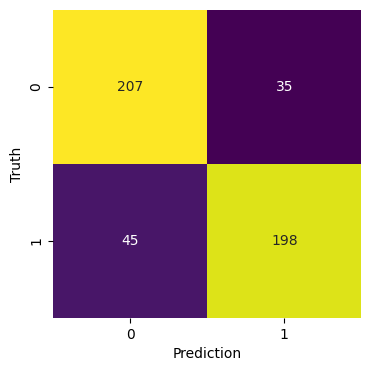

In [20]:
# plotting confusion matrix
plt.figure(figsize=(4,4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, square=True, cmap='viridis', fmt='d', cbar=False)
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.plot();